<p style="font-size:20px; text-align:center">CS6910 - Assignment 1</p>
<!-- <p style="font-size:18px; text-align:center">CS6910: Fundamentals of Deep Learning</p> -->

<p style="font-size:15px; text-align:">Arunesh J B (CS20B009)</p>

In [90]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
import sklearn.model_selection
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
import wandb


### Fashion Mnist Dataset

In [91]:
(X, Y), (X_test, Y_test) = mnist.load_data()

### Question 1

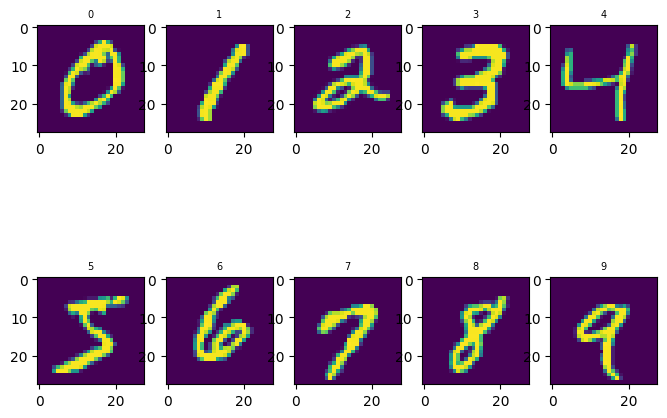

In [92]:
num_classes = len(np.unique(Y))
unique_classes = [X[np.where(Y == i)[0][0]] for i in range(num_classes)]
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
images = []
classes = []
for i in range(1, num_classes+1):
    plt.subplot(2, 5, i)
    plt.imshow(unique_classes[i-1])
    plt.title(class_names[i-1], fontdict={'fontsize': 7})
plt.show()


### Data Cleaning

In [93]:
num_features = np.shape(X)[1]*np.shape(X)[2]
X = X/255.0
X_test = X_test/255.0
X = X.reshape(np.shape(X)[0], 784)
X_test = X_test.reshape(np.shape(X_test)[0], 784)
X_train, Xv, Y_train, Yv = sklearn.model_selection.train_test_split(
    X, Y, test_size=0.1, random_state=4, shuffle=True)
print("Size of Training DataSet =", len(X_train))
print("Size of Validation DataSet =", len(Xv))
print("Size of Test DataSet =", len(X_test))
print("Number of classes =", num_classes)
print("Number of features =", num_features)
X_train = X_train.T
Xv = Xv.T
X_test = X_test.T


Size of Training DataSet = 54000
Size of Validation DataSet = 6000
Size of Test DataSet = 10000
Number of classes = 10
Number of features = 784


### Activation Functions

In [94]:
def sigmoid(x):
    return 1. /(1. + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0,x)

def der_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def der_tanh(x):
    return 1-(np.tanh(x)**2)

def der_relu(x):
    return (x>0)*1

def softmax(x):
    
    return (np.exp(x)/np.sum(np.exp(x),axis = 0))

def der_softmax(x):
    return softmax(x) * (1-softmax(x))

### Forward Propagation and Back Propagation

In [95]:
class Parameters:
    def __init__(self):
        pass
    
    def ForwardPropagation(self,X):
        W = self.W
        b = self.b
        A = [None]*len(W)
        H = [None]*len(b)
        for i in range(len(W)):
            if i == 0:
                A[i] = b[i] + W[i]@X
            else:
                A[i] = b[i] + W[i]@H[i-1]
            if i == len(W) - 1:
                H[i] = self.output_activation(A[i])
            else:
                H[i] = self.activation(A[i])
        self.A = A
        self.H = H
    
    def BackPropagation(self,X,Y):
        W = self.W
        b = self.b
        A = self.A
        H = self.H
        grad_a = [None]*len(A)
        grad_h = [None]*len(H)
        grad_w = [None]*len(W)
        grad_b = [None]*len(b)
        N = len(W)
        
        Y_hat = H[len(H)-1]
        grad_a[N-1] = Y_hat - Y
        for i in range(N-1,-1,-1):
            if i == 0:
                grad_w[i] = grad_a[i]@X.T
            else:
                grad_w[i] = grad_a[i]@H[i-1].T
            grad_b[i] = np.sum(grad_a[i],axis=1,keepdims=True)
            if i>0 :
                grad_h[i-1] = W[i].T@grad_a[i]
                grad_a[i-1] = grad_h[i-1]*self.der_activation(A[i-1])
        for i in range(N):
            W[i] += self.weight_decay*W[i]   
        self.grad_w = grad_w
        self.grad_b = grad_b
        self.W = W
    

### Stochastic Gradient Descent

In [96]:
class sgd:
    def __init__(self):
        pass
    
    def update_sgd_params(self,eta):
        grad_w = self.params.grad_w
        grad_b = self.params.grad_b
        W = self.params.W
        b = self.params.b
        N = len(W)
        for i in range(N):
            W[i] = W[i] - eta*grad_w[i]
            b[i] = b[i] - eta*grad_b[i]
        
    

### Momentum Based Gradient Descent

In [97]:
class momentum():
    
    def __init__(self):
        pass
    
    def updade_momentum_params(self,eta,beta):
        grad_w = self.params.grad_w
        grad_b = self.params.grad_b
        W = self.params.W
        b = self.params.b
        u_W = self.u_params.W
        u_b = self.u_params.b
        N = len(grad_w)
        for i in range(N):
            u_W[i] = beta*u_W[i] + grad_w[i]
            u_b[i] = beta*u_b[i] + grad_b[i]
            W[i] = W[i] - eta*u_W[i]
            b[i] = b[i] - eta*u_b[i]


### Nesterov Accelerated Gradient Descent

In [98]:
class nesterov():
    
    def __init__(self):
        pass
    
    def update_nesterov_params(self,eta,beta,X,Y):
        W = self.params.W
        b = self.params.b
        u_W = self.u_params.W
        u_b = self.u_params.b
        g_W = self.lookahead_params.W
        g_b = self.lookahead_params.b
        N = len(W)
        
        self.params.ForwardPropagation(X)
        self.params.BackPropagation(X,Y)
        
        grad_w = self.params.grad_w
        grad_b = self.params.grad_b
        
        for i in range(N):
            g_W[i] = grad_w[i]
            g_b[i] = grad_b[i]
        
        
        for i in range(N):
            u_W[i] = beta*u_W[i] + g_W[i]
            u_b[i] = beta*u_b[i] + g_b[i]
            W[i] = W[i] - eta*(beta*u_W[i] + g_W[i])
            b[i] = b[i] - eta*(beta*u_b[i] + g_b[i])
    


### RMSProp

In [99]:
class rmsprop():
    
    def __init__(self):
        pass
    
    def update_rmsprop_params(self,eta,beta,epsilon):
        grad_w = self.params.grad_w
        grad_b = self.params.grad_b
        W = self.params.W
        b = self.params.b
        u_W = self.u_params.W
        u_b = self.u_params.b
        N = len(W)
        for i in range(N):
            u_W[i] = beta*u_W[i] + (1-beta)*np.multiply(grad_w[i],grad_w[i])
            u_b[i] = beta*u_b[i] + (1-beta)*np.multiply(grad_b[i],grad_b[i])
            W[i] = W[i] - (eta*grad_w[i]/(np.sqrt(u_W[i]+epsilon)))
            b[i] = b[i] - (eta*grad_b[i]/(np.sqrt(u_b[i]+epsilon)))


### Adam

In [100]:
class adam():
    
    def __init__(self):
        pass
    
    def update_adam_params(self,eta,beta1,beta2,epsilon):
        grad_w = self.params.grad_w
        grad_b = self.params.grad_b
        W = self.params.W
        b = self.params.b
        u_W = self.u_params.W
        u_b = self.u_params.b
        m_W = self.m_params.W
        m_b = self.m_params.b
        N = len(W)
        for i in range(N):
            m_W[i] = beta1*m_W[i] + (1-beta1)*grad_w[i]
            u_W[i] = beta2*u_W[i] + (1-beta2)*np.square(grad_w[i])
            m_hat_W = m_W[i]/(1.0-np.power(beta1,i+1))
            u_hat_W = u_W[i]/(1.0-np.power(beta2,i+1))
            W[i] = W[i] - (eta/(np.sqrt(u_hat_W)+epsilon))*m_hat_W
            
            m_b[i] = beta1*m_b[i] + (1-beta1)*grad_b[i]
            u_b[i] = beta2*u_b[i] + (1-beta2)*np.square(grad_b[i])
            m_hat_b = m_b[i]/(1.0-np.power(beta1,i+1))
            u_hat_b = u_b[i]/(1.0-np.power(beta2,i+1))
            b[i] = b[i] - (eta/(np.sqrt(u_hat_b)+epsilon))*m_hat_b


### NAdam

In [101]:
class nadam():
    
    def __init__(self):
        pass
    
    def update_nadam_params(self,eta,beta,beta1,beta2,epsilon,X,Y):
        W = self.params.W
        b = self.params.b
        u_W = self.u_params.W
        u_b = self.u_params.b
        m_W = self.m_params.W
        m_b = self.m_params.b
        g_W = self.lookahead_params.W
        g_b = self.lookahead_params.b
        N = len(W)
        
        self.params.ForwardPropagation(X)
        self.params.BackPropagation(X,Y)
        
        grad_w = self.params.grad_w
        grad_b = self.params.grad_b
        
        for i in range(N):
            g_W[i] = grad_w[i]
            g_b[i] = grad_b[i]
            
        for i in range(N):
            m_W[i] = beta1*m_W[i] + g_W[i]
            m_b[i] = beta1*m_b[i] + g_b[i]
            
            u_W[i] = beta2*u_W[i] + (1-beta2)*np.square(grad_w[i])
            u_b[i] = beta2*u_b[i] + (1-beta2)*np.square(grad_b[i])
            
            m_hat_W = (beta1*m_W[i] + g_W[i])/(1-np.power(beta1,i+1))
            m_hat_b = (beta1*m_b[i] + g_b[i])/(1-np.power(beta1,i+1))
            u_hat_W = u_W[i]/(1-np.power(beta2,i+1))
            u_hat_b = u_b[i]/(1-np.power(beta2,i+1))
            
            W[i] = W[i] - (eta*m_hat_W/(np.sqrt(u_hat_W)+epsilon))
            b[i] = b[i] - (eta*m_hat_b/(np.sqrt(u_hat_b)+epsilon))
        

### Insert Your optimizer here

In [102]:
class optimizer_name():
    '''
        Refer to the above optimizers for better understanding on how to use this class
    '''
    def __init__(self):
        pass
    
    def update_optimizer_name_params(self,):
        '''
            Add your code to update parameters
        '''
        pass

### Feedforward Neural Network

In [103]:
class NeuralNet:
    '''
        weight_initializers : dictionary with random , xavier
        weight_initializer : function
        activation_funtions : dictionary with sigmoid, tanh, relu
        der_activation_functions : dictionary with derivatives of the above
        optimizer_funtions : dictionary with sgd, momentum, nesterov, rmsprop, adam, nadam}
        activation : string
        opitmizer : string
        learning_rate : int
        batch_size : int
        num_epochs : int
        num_features : dimension of X
        num_hidden_layers : int, number of hidden layers
        output_layer_dim : int
        hidden_layer_dims : np.array with num_neurons in all hidden layer 
        weight_Decay : L2 regularisation
        X_train : Training Data (n,d)
        Y_train : Training Data (n,)
        Xv : Validation Data (n,d)
        Yv : Validation Data (n,)
        hidden_layers : np.array of objects to class hidden_layer dimensions = num_hidden_layers
        output_layer : object to hidden_layer class
        params : It is a object of class parameter which has the weights and biases of the neural network
        optimizer_object : object to the optimizer class, initialised in the initialize_neuralnet funciton
        beta : momentum,neterov,rmsprop,nadam
        beta1 : adam,nadam
        beta2 : adam,nadam
        epsilon : rmsprop,adam,nadam
    '''
    def __init__(self,
                 num_features,
                 weight_initializer,
                 num_hidden_layers,
                 hidden_layer_dims,
                 optimizer,
                 learning_rate,
                 activation,
                 X_train,
                 Y_train,
                 Xv,
                 Yv,
                 weight_decay,
                 output_layer_dim,
                 batch_size,
                 num_epochs,
                 loss = 'cross_entropy',
                 output_activation = softmax,
                 der_output_activation = der_softmax,
                 beta=0.9,
                 epsilon=1e-8,
                 beta1=0.9,
                 beta2=0.999):
        self.weight_initializers = {"random": self.random_initialization, "xavier": self.xavier_intialization}
        self.weight_initializer = self.weight_initializers[weight_initializer]
        self.activation_functions = {"sigmoid": sigmoid, "tanh": tanh, "ReLU": relu}
        self.der_activation_functions = {"sigmoid": der_sigmoid, "tanh": der_tanh, "ReLU": der_relu}
        self.loss_functions = {'cross_entropy':self.Cross_Entropy_Loss,'mse' : self.Square_Error_Loss}
        self.loss = self.loss_functions[loss]
        '''
            Add your optimizer function and class in the below dictionaries
        '''
        self.optimizer_functions = {"sgd": self.sgd, "momentum": self.momentum,"nesterov": self.nesterov, "rmsprop": self.rmsprop, "adam": self.adam, "nadam": self.nadam}
        self.optimizer_classes = {"sgd": sgd, "momentum": momentum,"nesterov": nesterov, "rmsprop": rmsprop, "adam": adam, "nadam": nadam}
        self.activation = self.activation_functions[activation]
        self.optimizer = self.optimizer_functions[optimizer]
        self.optimizer_class = self.optimizer_classes[optimizer]
        self.der_activation = self.der_activation_functions[activation]
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.num_hidden_layers = num_hidden_layers
        self.output_layer_dim = output_layer_dim
        self.hidden_layer_dims = hidden_layer_dims
        self.num_features = num_features
        self.output_activation = output_activation
        self.der_output_activation = der_output_activation
        self.weight_decay = weight_decay
        self.X_train = X_train
        self.Y_train = Y_train
        self.old_Y_train = Y_train
        self.Xv = Xv
        self.Yv = Yv
        self.old_Yv = Yv
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.num_classes = self.output_layer_dim
        # return self
        
    def Square_Error_Loss(self,Y_pred,Y_actual):
        return np.mean((Y_pred-Y_actual)**2)
    
    def Cross_Entropy_Loss(self,Y_pred,Y_actual):
        return (-1.0*np.sum(np.multiply(Y_actual+1,np.log(Y_pred+1))))/float(Y_pred.shape[0])
    
    def random_initialization(self, in_layer, out_layer):
        return np.random.randn(in_layer, out_layer)

    def xavier_intialization(self, in_layer, out_layer):
        return np.random.randn(in_layer, out_layer)* np.sqrt(2 / (in_layer + out_layer))
    
    '''
        The below optimizer functions are used to call the update_params methods in of their respective params
    '''
    
    def sgd(self,X,Y):
        sgd_obj = self.optimizer_object
        parameters = self.params
        parameters.ForwardPropagation(X)
        parameters.BackPropagation(X,Y)
        sgd_obj.update_sgd_params(self.learning_rate)
        # for i in range(len(self.params.W)):
        #     print(self.params.W[i])
    
    def momentum(self,X,Y):
        momentum_obj = self.optimizer_object
        parameters = self.params
        parameters.ForwardPropagation(X)
        parameters.BackPropagation(X,Y)
        momentum_obj.updade_momentum_params(self.learning_rate,self.beta)

    def nesterov(self,X,Y):
        nesterov_obj = self.optimizer_object
        nesterov_obj.update_nesterov_params(self.learning_rate,self.beta,X,Y)
    
    def rmsprop(self,X,Y):
        rmsprop_obj = self.optimizer_object
        parameters = self.params
        parameters.ForwardPropagation(X)
        parameters.BackPropagation(X,Y)
        rmsprop_obj.update_rmsprop_params(self.learning_rate,self.beta,self.epsilon)
    
    def adam(self,X,Y):
        adam_obj = self.optimizer_object
        parameters = self.params
        parameters.ForwardPropagation(X)
        parameters.BackPropagation(X,Y)
        adam_obj.update_adam_params(self.learning_rate,self.beta1,self.beta2,self.epsilon)
    
    def nadam(self,X,Y):
        nadam_obj = self.optimizer_object
        nadam_obj.update_nadam_params(self.learning_rate,self.beta,self.beta1,self.beta2,self.epsilon,X,Y)
    
    def optimzizer_name(self,X,Y):
        '''
            May implement forward and backpropagation here 
            Add code to create an object to your optimizer class
            Then use this object to call your optimizer_update method 
        '''
        pass
    
    def sanitize_Y(self):
        
        temp = np.zeros((self.num_classes,self.Y_train.shape[0]))
        for i in range(self.Y_train.shape[0]) :
            temp[int(self.Y_train[i])][i] = 1
        self.Y_train = temp
        
        temp = np.zeros((self.num_classes,self.Yv.shape[0]))
        for i in range(self.Yv.shape[0]) :
            temp[int(self.Yv[i])][i] = 1
        self.Yv = temp
        
    def initialize_NeuralNet(self):
        self.sanitize_Y()
        self.optimizer_object = self.optimizer_class()
        self.params = self.initialize_parameters()
        self.optimizer_object.params = self.params
        self.optimizer_object.u_params = self.zero_initializer()
        self.optimizer_object.m_params = self.zero_initializer()
        self.optimizer_object.lookahead_params = self.zero_initializer()
        '''
            can add required optimizer params and 
            initialize them here 
        '''
        # pass
    
    
    def add_hidden(self,num_neurons,pos):
        '''
        This function can be used to insert a layer at any position
        (0 indexing)
        '''
        self.hidden_layer_dims.insert(pos,num_neurons)
        self.num_hidden_layers += 1
        
    def zero_initializer(self):
        params = Parameters()
        W = []
        b = []
        in_layer, out_layer = self.num_features,self.hidden_layer_dims[1]
        for i in range(self.num_hidden_layers):
            if  i == 0:
                in_layer = self.num_features
            else:
                in_layer = self.hidden_layer_dims[i-1]
                
            if i == self.num_hidden_layers-1:
                out_layer = self.output_layer_dim
            else:
                out_layer = self.hidden_layer_dims[i+1]
            W.append(np.zeros(shape = (self.hidden_layer_dims[i],in_layer)))
            b.append(np.zeros(shape = (self.hidden_layer_dims[i],1)))
        W.append(np.zeros(shape = (self.num_classes,self.hidden_layer_dims[self.num_hidden_layers-1])))
        b.append(np.zeros(shape=(self.num_classes,1)))
        params.W = W
        params.b = b
        params.activation = self.activation
        params.output_activation = self.output_activation
        params.der_activation = self.der_activation
        params.weight_decay = self.weight_decay
        return params
    
    def initialize_parameters(self):
        params = Parameters()
        W = []
        b = []
        in_layer, out_layer = self.num_features,self.hidden_layer_dims[1]
        for i in range(self.num_hidden_layers):
            if  i == 0:
                in_layer = self.num_features
            else:
                in_layer = self.hidden_layer_dims[i-1]
                
            if i == self.num_hidden_layers-1:
                out_layer = self.output_layer_dim
            else:
                out_layer = self.hidden_layer_dims[i+1]
            W.append(self.weight_initializer(self.hidden_layer_dims[i],in_layer))
            b.append(np.zeros(shape=(self.hidden_layer_dims[i],1)))
        W.append(self.weight_initializer(self.num_classes,self.hidden_layer_dims[self.num_hidden_layers-1]))
        b.append(np.zeros(shape=(self.num_classes,1)))
        params.W = W
        params.b = b
        params.activation = self.activation
        params.output_activation = self.output_activation
        params.der_activation = self.der_activation
        params.weight_decay = self.weight_decay
        return params
    
    def fit_NeuralNet(self):
        self.initialize_NeuralNet()
        for curr_epoch in range(self.num_epochs):
            print("Epoch Number : ",curr_epoch+1)  
            for i in range(0,self.X_train.shape[1],self.batch_size):
                curr_batch = min(self.X_train.shape[1]-i,self.batch_size)
                self.optimizer(self.X_train[:,i:i+curr_batch],self.Y_train[:,i:i+curr_batch])
            train_acc,validation_acc,training_loss,validation_loss = self.accuracy_NeuralNet(self.old_Y_train,self.old_Yv)
            print("train accuracy =",train_acc,", validation accuracy =",validation_acc,", training loss =",training_loss,", validation loss =",validation_loss)
        # pass
    
    def predict_NeuralNet(self,X):
        self.params.ForwardPropagation(X)
        Y_pred = np.argmax(self.params.H[len(self.params.H)-1],axis=0)
        return Y_pred
    
    def accuracy_NeuralNet(self,Y_train,Yv):
        Y_train_pred = self.predict_NeuralNet(self.X_train)
        Yv_pred = self.predict_NeuralNet(self.Xv)
        training_Loss = self.loss(Y_train_pred,self.old_Y_train)
        validation_Loss = self.loss(Yv_pred,self.old_Yv)
        return self.accuracy_score(Y_train_pred,Y_train),self.accuracy_score(Yv_pred,Yv),training_Loss,validation_Loss
    
    def accuracy_score(self, Y_pred, Y_train):
        return np.sum(Y_pred == Y_train)/Y_train.shape[0]


### Model 1

In [72]:
NUM_FEATURES = X_train.shape[0]
WEIGHT_INITIALIZER = "xavier"
NUM_HIDDEN_LAYERS = 5
# HIDDEN_LAYER_DIMS = (128+np.arange(NUM_HIDDEN_LAYERS)).astype(int)
HIDDEN_LAYER_DIMS = (128+np.zeros(NUM_HIDDEN_LAYERS)).astype(int)
OPTIMIZER = "adam"
LEARNING_RATE = 0.001
ACTIVATION = "ReLU"
OUTPUT_LAYER_DIM = num_classes
BATCH_SIZE = 128
EPOCHS = 5
WEIGHT_DECAY = 0.0005

N = NeuralNet(num_features = NUM_FEATURES,
                weight_initializer = WEIGHT_INITIALIZER,
                num_hidden_layers = NUM_HIDDEN_LAYERS,
                hidden_layer_dims = HIDDEN_LAYER_DIMS,
                optimizer = OPTIMIZER,
                learning_rate = LEARNING_RATE,
                activation = ACTIVATION,
                X_train = X_train,
                Y_train = Y_train,
                Xv = Xv,
                Yv = Yv,
                # loss = 'mse',
                weight_decay=WEIGHT_DECAY,
                output_layer_dim = OUTPUT_LAYER_DIM,
                batch_size = BATCH_SIZE,
                num_epochs = EPOCHS)
N.fit_NeuralNet()
Y_pred_test = N.predict_NeuralNet(X_test)
print("Test Accuracy :",N.accuracy_score(Y_pred_test,Y_test))

Epoch Number :  1
train accuracy = 0.9605185185185185 , validation accuracy = 0.9583333333333334 , training loss = -10.030493786309046 , validation loss = -9.977060403080598
Epoch Number :  2
train accuracy = 0.9708148148148148 , validation accuracy = 0.9595 , training loss = -10.017346992123601 , validation loss = -9.943505106775053
Epoch Number :  3
train accuracy = 0.9764814814814815 , validation accuracy = 0.9618333333333333 , training loss = -10.022624552069436 , validation loss = -9.944192198881955
Epoch Number :  4
train accuracy = 0.978462962962963 , validation accuracy = 0.9573333333333334 , training loss = -10.046955386242994 , validation loss = -9.949031844703434
Epoch Number :  5


/tmp/ipykernel_16824/2428591566.py:21: RuntimeWarning: overflow encountered in exp
  return (np.exp(x)/np.sum(np.exp(x),axis = 0))
/tmp/ipykernel_16824/2428591566.py:21: RuntimeWarning: invalid value encountered in divide
  return (np.exp(x)/np.sum(np.exp(x),axis = 0))


train accuracy = 0.9841851851851852 , validation accuracy = 0.9595 , training loss = -10.076995693361162 , validation loss = -9.987209038165327
Test Accuracy : 0.9637


/tmp/ipykernel_16824/2428591566.py:21: RuntimeWarning: overflow encountered in exp
  return (np.exp(x)/np.sum(np.exp(x),axis = 0))
/tmp/ipykernel_16824/2428591566.py:21: RuntimeWarning: invalid value encountered in divide
  return (np.exp(x)/np.sum(np.exp(x),axis = 0))


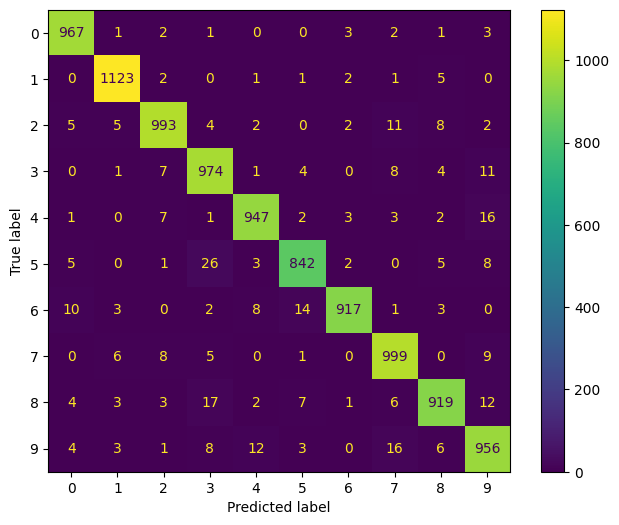

In [73]:
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
Y_pred_test = N.predict_NeuralNet(X_test)
confusion_matrix = confusion_matrix(Y_test,Y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_names  )
cm_display.plot()
plt.rcParams['figure.figsize'] = [8,6]
plt.show() 

### Model 2

In [88]:
NUM_FEATURES = X_train.shape[0]
WEIGHT_INITIALIZER = "xavier"
NUM_HIDDEN_LAYERS = 5
# HIDDEN_LAYER_DIMS = (128+np.arange(NUM_HIDDEN_LAYERS)).astype(int)
HIDDEN_LAYER_DIMS = (128+np.zeros(NUM_HIDDEN_LAYERS)).astype(int)
OPTIMIZER = "nadam"
LEARNING_RATE = 0.001
ACTIVATION = "ReLU"
OUTPUT_LAYER_DIM = num_classes
BATCH_SIZE = 128
EPOCHS = 5
WEIGHT_DECAY = 0.0005

N = NeuralNet(num_features = NUM_FEATURES,
                weight_initializer = WEIGHT_INITIALIZER,
                num_hidden_layers = NUM_HIDDEN_LAYERS,
                hidden_layer_dims = HIDDEN_LAYER_DIMS,
                optimizer = OPTIMIZER,
                learning_rate = LEARNING_RATE,
                activation = ACTIVATION,
                X_train = X_train,
                Y_train = Y_train,
                Xv = Xv,
                Yv = Yv,
                # loss = 'mse',
                weight_decay=WEIGHT_DECAY,
                output_layer_dim = OUTPUT_LAYER_DIM,
                batch_size = BATCH_SIZE,
                num_epochs = EPOCHS)
N.fit_NeuralNet()
Y_pred_test = N.predict_NeuralNet(X_test)
print("Test Accuracy :",N.accuracy_score(Y_pred_test,Y_test))


Epoch Number :  1
train accuracy = 0.9572222222222222 , validation accuracy = 0.9488333333333333 , training loss = -10.066294460675824 , validation loss = -10.018069146359043
Epoch Number :  2
train accuracy = 0.9675370370370371 , validation accuracy = 0.9576666666666667 , training loss = -10.04250263001671 , validation loss = -9.988019066219463
Epoch Number :  3
train accuracy = 0.9725370370370371 , validation accuracy = 0.9595 , training loss = -10.045888798415023 , validation loss = -9.96587467031262
Epoch Number :  4
train accuracy = 0.9752592592592593 , validation accuracy = 0.9583333333333334 , training loss = -10.04642275196206 , validation loss = -9.935943824534515
Epoch Number :  5
train accuracy = 0.9641111111111111 , validation accuracy = 0.9455 , training loss = -9.995226010562297 , validation loss = -9.894444283659276
Test Accuracy : 0.946


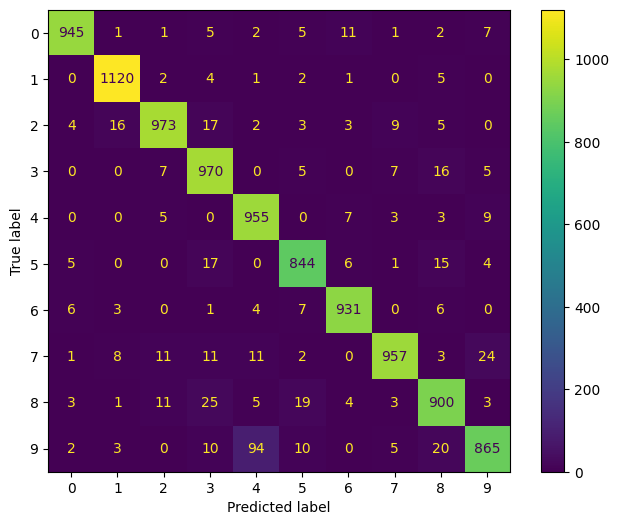

In [89]:
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
Y_pred_test = N.predict_NeuralNet(X_test)
confusion_matrix = confusion_matrix(Y_test,Y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_names  )
cm_display.plot()
plt.rcParams['figure.figsize'] = [8,6]
plt.show() 

### Model 3

In [104]:
NUM_FEATURES = X_train.shape[0]
WEIGHT_INITIALIZER = "xavier"
NUM_HIDDEN_LAYERS = 3
# HIDDEN_LAYER_DIMS = (128+np.arange(NUM_HIDDEN_LAYERS)).astype(int)
HIDDEN_LAYER_DIMS = (128+np.zeros(NUM_HIDDEN_LAYERS)).astype(int)
OPTIMIZER = "nesterov"
LEARNING_RATE = 0.001
ACTIVATION = "ReLU"
OUTPUT_LAYER_DIM = num_classes
BATCH_SIZE = 128
EPOCHS = 3
WEIGHT_DECAY = 0.0005

N = NeuralNet(num_features = NUM_FEATURES,
                weight_initializer = WEIGHT_INITIALIZER,
                num_hidden_layers = NUM_HIDDEN_LAYERS,
                hidden_layer_dims = HIDDEN_LAYER_DIMS,
                optimizer = OPTIMIZER,
                learning_rate = LEARNING_RATE,
                activation = ACTIVATION,
                X_train = X_train,
                Y_train = Y_train,
                Xv = Xv,
                Yv = Yv,
                # loss = 'mse',
                weight_decay=WEIGHT_DECAY,
                output_layer_dim = OUTPUT_LAYER_DIM,
                batch_size = BATCH_SIZE,
                num_epochs = EPOCHS)
N.fit_NeuralNet()
Y_pred_test = N.predict_NeuralNet(X_test)
print("Test Accuracy :",N.accuracy_score(Y_pred_test,Y_test))

Epoch Number :  1
train accuracy = 0.9611851851851851 , validation accuracy = 0.952 , training loss = -10.05843008058433 , validation loss = -10.00387241245345
Epoch Number :  2
train accuracy = 0.972 , validation accuracy = 0.9621666666666666 , training loss = -10.044878871127832 , validation loss = -9.985459854629276
Epoch Number :  3
train accuracy = 0.9764444444444444 , validation accuracy = 0.9671666666666666 , training loss = -10.05045954224328 , validation loss = -9.98919291060186
Test Accuracy : 0.9685


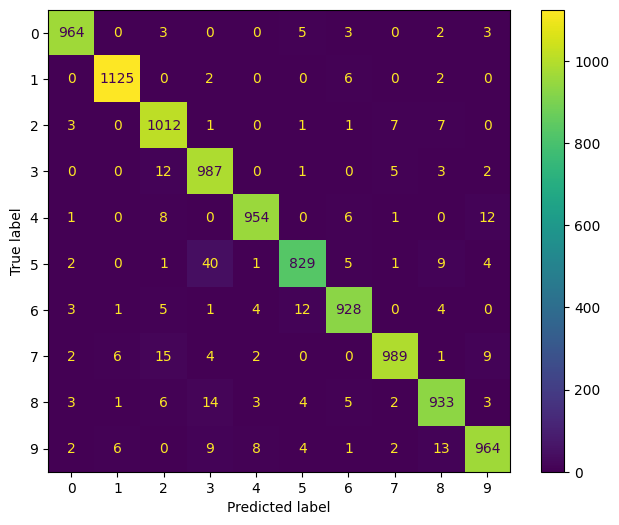

In [105]:
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
Y_pred_test = N.predict_NeuralNet(X_test)
confusion_matrix = confusion_matrix(Y_test,Y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_names  )
cm_display.plot()
plt.rcParams['figure.figsize'] = [8,6]
plt.show() 